# ビデオのタイトルをEmbeddingしてモデルの性能がどう変わるか見る

In [1]:
from lib.repository.load_data import YoutubeVideoDataRepository
from lib.service.data import YoutubeVideoDataService

path2data = "/Users/y.kotani/Downloads/30分以内に投稿された動画データ.xlsx"
repository = YoutubeVideoDataRepository(path2data=path2data)
service = YoutubeVideoDataService(repository=repository)

transformed_data = service.get_transformed_data()

In [14]:
transformed_data

,channel_name,channel_country,channel_default_language,subscriber_count,video_count,channel_topic_ids,channel_topic_catrgories,published_at,channel_id,title,...,sin_hour,cos_hour,duration_min,day_of_week_str_Friday,day_of_week_str_Monday,day_of_week_str_Saturday,day_of_week_str_Sunday,day_of_week_str_Thursday,day_of_week_str_Tuesday,day_of_week_str_Wednesday
9,「ジョジョの奇妙な冒険 ラストサバイバー」公式チャンネル,JP,NaN,25800,85,"/m/02ntfj, /m/0bzvm2, /m/025zzc, /m/0403l3g, /...",https://en.wikipedia.org/wiki/Action-adventure...,2023-11-25 17:15:00+09:00,UCYPvAwZP8pZhSMW8qs7cVCw,Drilling Work Put On Hold Due To Obstruction; ...,...,-0.965926,-0.258819,3.516667,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11,ANNnewsCH,JP,NaN,3660000,94360,"/m/098wr, /m/05qt0","https://en.wikipedia.org/wiki/Society, https:/...",2023-11-25 17:36:01+09:00,UCMmpLL2ucRHAXbNHiCPyIyg,ARY News 1 PM Headlines 25th November 2023 | 𝐏...,...,-0.965926,-0.258819,7.883333,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13,たかぼん / takabon,JP,NaN,23700,258,"/m/07c1v, /m/019_rr","https://en.wikipedia.org/wiki/Technology, http...",2023-11-25 17:30:18+09:00,UCckHqySbfy5FcPP6MD_S-Yg,Uttarkashi Tunnel Rescue Latest: “No obstacle ...,...,-0.965926,-0.258819,3.100000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17,autofficial,JP,NaN,152000,951,"/m/0410tth, /m/019_rr, /m/06ntj, /m/07yv9","https://en.wikipedia.org/wiki/Motorsport, http...",2023-11-25 17:15:28+09:00,UCz2yxQJZgiB_5elTzqV7FiQ,LIVE: BOL News Bulletin At 12 PM | Imran Khan ...,...,-0.965926,-0.258819,52.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19,でいすいのゲームちゃんねる/DeisuiGames,JP,ja,187000,3072,"/m/0bzvm2, /m/02ntfj, /m/04q1x3q, /m/025zzc, /...",https://en.wikipedia.org/wiki/Video_game_cultu...,2023-11-25 17:15:01+09:00,UCXIJgqnII2ZOINSWNOGFThA,Pressure mounts on Biden to intervene in Israe...,...,-0.965926,-0.258819,5.116667,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17867,NottinTV,JP,ja,305000,3611,"/m/025zzc, /m/03hf_rm, /m/0403l3g, /m/0bzvm2","https://en.wikipedia.org/wiki/Action_game, htt...",2023-12-17 14:19:04+09:00,UC2rMjw5mEdzInjkE9wTyojg,爽快！青の鼻パックを剥がすASMR,...,-0.500000,-0.866025,0.283333,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17868,Jurard T Rexford Ch. HOLOSTARS-EN,JP,NaN,69000,30,"/m/0403l3g, /m/02ntfj, /m/025zzc, /m/0bzvm2",https://en.wikipedia.org/wiki/Role-playing_vid...,2023-12-17 14:30:05+09:00,UCj4NxvRjWcrgD9N1jCMDnmA,【Steamセール】年越しの瞬間までゲームを遊ぼう！おすすめセール情報20選【12月22日まで】,...,-0.500000,-0.866025,21.233333,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17870,K-POP ラボ,JP,ja,33000,262,"/m/04rlf, /m/064t9, /m/028sqc, /m/02jjt","https://en.wikipedia.org/wiki/Music, https://e...",2023-12-17 14:15:00+09:00,UCEplowqLgI_FXKgQUcSGGCQ,[銀河連合]【速報】これは警鐘です！🙌X2.87最大の太陽フレア🌈銀河連合からのメッセージ ...,...,-0.500000,-0.866025,6.650000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17871,ハッキー・ゲームちゃんねる【Hacky Game】,JP,NaN,100000,762,"/m/025zzc, /m/0403l3g, /m/0bzvm2, /m/02ntfj","https://en.wikipedia.org/wiki/Action_game, htt...",2023-12-17 14:27:35+09:00,UCdSrYZ_25L4qJo1bTaQPtbw,ইফাত রনি খেলা দেখা এশিয়াকাপ ফাইনাল বাংলা ধারাভ...,...,-0.500000,-0.866025,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [2]:
transformed_data = transformed_data[transformed_data["channel_country"] == "JP"]

In [3]:
transformed_data["title"].isna().sum()

0

In [4]:
len(set(transformed_data["title"]))

5773

In [17]:
from sentence_transformers import SentenceTransformer, util
import torch

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [20]:
corpus = list(transformed_data["title"])
corpus_embeddings = model.encode(corpus[:5])

In [21]:
type(corpus_embeddings)

numpy.ndarray

In [7]:
# one-hot encoding: day_of_week_str
import pandas as pd

transformed_data = pd.get_dummies(transformed_data, columns=["day_of_week_str"], dtype=float)

In [8]:
# カラムの定義
hour_cols = ["sin_hour", "cos_hour"]
dayOfWeek_cols = list(filter(lambda x: x.startswith("day_of_week_str"), transformed_data.columns))

features = ["minutes_diff", *hour_cols, *dayOfWeek_cols, "comment_count", "like_count", "favorite_count", "duration_min", "subscriber_count"]
target = "view_count"

In [9]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

X = transformed_data[features]
X_with_embedding = np.hstack([X, corpus_embeddings.numpy()])
y = transformed_data[target].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_with_embedding, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [10]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# RMSE
print("RMSE train: ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("RMSE test: ", np.sqrt(mean_squared_error(y_test, y_test_pred)))

# R2
print("R2 train: ", r2_score(y_train, y_train_pred))
print("R2 test: ", r2_score(y_test, y_test_pred))

RMSE train:  30888.46483296495
RMSE test:  25364.866300976963
R2 train:  0.8807390659750712
R2 test:  0.7369450930690278


In [11]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'rmse',
}

model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=1000, callbacks=[lgb.early_stopping(stopping_rounds=50)])

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# RMSE
print("RMSE train: ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("RMSE test: ", np.sqrt(mean_squared_error(y_test, y_test_pred)))

# R2
print("R2 train: ", r2_score(y_train, y_train_pred))
print("R2 test: ", r2_score(y_test, y_test_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99254
[LightGBM] [Info] Number of data points in the train set: 4655, number of used features: 398
[LightGBM] [Info] Start training from score 14212.108271
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's rmse: 64154.1	valid_1's rmse: 38218.9
RMSE train:  64154.068206728254
RMSE test:  38218.8762437725
R2 train:  0.4855372191992561
R2 test:  0.40277623785565364


# LightGBMのCV

In [12]:
# cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)
validation_scores = {
    "RMSE_train": [],
    "RMSE_test": [],
    "R2_train": [],
    "R2_test": [],
    "MAE_train": [],
    "MAE_test": []
}

for train_index, test_index in kf.split(X_with_embedding):
    X_train, X_test = X_with_embedding[train_index], X_with_embedding[test_index]
    y_train, y_test = y[train_index], y[test_index]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
    }
    model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=1000, callbacks=[lgb.early_stopping(stopping_rounds=50)])

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # RMSE
    validation_scores["RMSE_train"].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    validation_scores["RMSE_test"].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    # R2
    validation_scores["R2_train"].append(r2_score(y_train, y_train_pred))
    validation_scores["R2_test"].append(r2_score(y_test, y_test_pred))

    # MAE
    validation_scores["MAE_train"].append(mean_absolute_error(y_train, y_train_pred))
    validation_scores["MAE_test"].append(mean_absolute_error(y_test, y_test_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99257
[LightGBM] [Info] Number of data points in the train set: 4655, number of used features: 398
[LightGBM] [Info] Start training from score 14212.108271
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's rmse: 64154.1	valid_1's rmse: 38218.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99257
[LightGBM] [Info] Number of data points in the train set: 4655, number of used features: 398
[LightGBM] [Info] Start training from score 13880.389044
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	training's rmse: 48899	valid_1's rmse: 40997.4
[LightGB

In [13]:
from pprint import pprint

pprint(validation_scores)

{'MAE_test': [8089.064441257911,
              9915.642423339137,
              9548.058675859858,
              10595.355790060858,
              9661.57776957288],
 'MAE_train': [7504.486129751893,
               5708.379165220935,
               1954.2133991117676,
               2585.126227533387,
               1496.071533782232],
 'R2_test': [0.40277623785565375,
             0.46907670077764363,
             0.37461147861259736,
             0.7417939329515882,
             0.7762497270898109],
 'R2_train': [0.4855372191992561,
              0.6942838145231724,
              0.9702676160067981,
              0.9322929902892583,
              0.9712070035456171],
 'RMSE_test': [38218.876243772494,
               40997.39820789435,
               102437.90878347147,
               37742.415197144604,
               38232.481638855636],
 'RMSE_train': [64154.06820672826,
                48898.98090558819,
                11460.47075372688,
                22128.901931017663,
      

# Embeddingを次元圧縮してみる

[0.07776119 0.05041572 0.04427382 0.0350518  0.02884196 0.02545387
 0.02344882 0.02167369 0.02014964 0.01827611 0.01666459 0.01585103
 0.01508176 0.01396476 0.01319851 0.01283404 0.0119977  0.01182157
 0.01132241 0.01120515 0.01068502 0.00992973 0.00985491 0.00923948
 0.00909673 0.00870599 0.00863619 0.00827954 0.00809806 0.00800788
 0.00785109 0.00760517 0.00753883 0.00749141 0.00728409 0.00702597
 0.00691692 0.0068262  0.00660705 0.00648866 0.00641322 0.0062169
 0.00615458 0.00599875 0.00581797 0.00568635 0.00566648 0.00557442
 0.00536598 0.00531232 0.00512522 0.00505228 0.00502352 0.00499512
 0.00487444 0.00482047 0.0047531  0.00465883 0.00452873 0.00446783
 0.00439974 0.00433668 0.00430482 0.00424293 0.00412743 0.00396018
 0.0039119  0.00383928 0.00380395 0.00372499 0.0036308  0.00356843
 0.00353766 0.00350699 0.00345827 0.00337192 0.00332361 0.00326955
 0.00322731 0.00313667 0.0030895  0.00304658 0.00302202 0.00292369
 0.00290926 0.0028411  0.00278794 0.00273102 0.00270413 0.00269

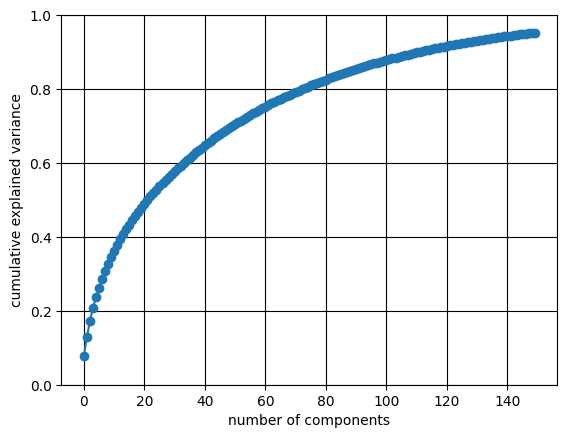

In [34]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=150)
pca.fit(corpus_embeddings)

print(pca.explained_variance_ratio_)

# cumsum plot
import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.grid(
    which='major',
    color='black',
    linestyle='-'
)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.ylim(0, 1)
plt.show()


torch.Size([1560, 384])